## Goal : check shear SNR prediction vs CLMM mock data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from magnification_library import *
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.io import ascii
from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy import stats, interpolate

import clmm
import clmm.support.mock_data as mock
import pyccl

In [2]:
#define clmm cosmology
cosmo = clmm.Cosmology(H0 = 70.0, Omega_dm0 = 0.2648, Omega_b0 = 0.0448, Omega_k0 = 0.0)
#equivalent to cosmo.get_desc()
print ("CLMM backend = ", cosmo.backend)

#ccl object
cosmo_ccl = pyccl.Cosmology(Omega_c = cosmo.be_cosmo.Odm0, Omega_b=cosmo.be_cosmo.Ob0,
                      h=cosmo.be_cosmo.h, sigma8= 0.80, n_s=0.963)

CLMM backend =  ct


### Source / lens properties

In [3]:
#Source galaxies properties

#SHEAR LSST
s_e = 0.26
n_e = 26 / u.arcmin**2 # fiducial number after blending + masking https://arxiv.org/pdf/1305.0793.pdf

def shear_pdz(z):
    norm =quad(lambda z: trunc_pdf(z, 1.24, 1.01, 0.51, 0, 3), 0, np.inf)[0]
    return trunc_pdf(z, 1.24, 1.01, 0.51, 0, 3)/norm   

In [4]:
#Lens properties

cluster_m = 5.e14
cluster_z = 0.3
concentration = 3.
Delta = 200 # mass definition with respect to critical overdensity
cluster_ra = 0.0
cluster_dec = 0.0
zsrc_min=cluster_z+0.1

### CLMM mock data

In [5]:
N_stack = 10

In [6]:
#without shape noise

mock_catalogs_ideal = []

for i in range(N_stack):
    mock_catalogs_ideal.append(mock.generate_galaxy_catalog(
    cluster_m, cluster_z, concentration, cosmo, 'chang13', Delta, massdef='mean', halo_profile_model='nfw', zsrc_min=zsrc_min,
    zsrc_max=3.0, field_size=10, shapenoise=0, photoz_sigma_unscaled=None, ngal_density=n_e.value))

In [7]:
#with shape noise

mock_catalogs = []

for i in range(N_stack):
    mock_catalogs.append(mock.generate_galaxy_catalog(
    cluster_m, cluster_z, concentration, cosmo, 'chang13', Delta, massdef='mean', halo_profile_model='nfw', zsrc_min=zsrc_min,
    zsrc_max=3.0, field_size=10, shapenoise=s_e, photoz_sigma_unscaled=None, ngal_density=n_e.value))

### Check CLMM mock galaxy samples

In [8]:
boxsize = cosmo.be_cosmo.arcsec_per_kpc_proper(cluster_z).to(u.deg/u.Mpc)*5

Text(0, 0.5, 'dec - offset [deg]')

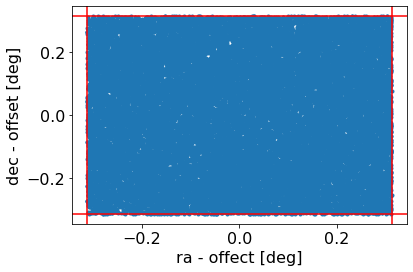

In [9]:
plt.plot(mock_catalogs[i]['ra'], mock_catalogs[i]['dec'],'.')


plt.axvline(boxsize.value,color='red')
plt.axvline(-boxsize.value,color='red')

plt.axhline(boxsize.value,color='red')
plt.axhline(-boxsize.value,color='red')

plt.xlabel('ra - offect [deg]')
plt.ylabel('dec - offset [deg]')

Text(0.5, 0, 'z')

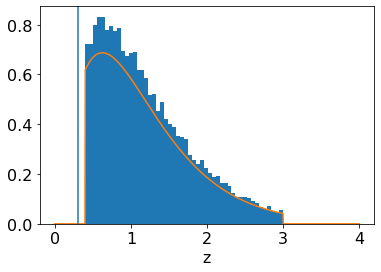

In [10]:
z_s = np.linspace(0.001, 4, 1000)
plt.hist(mock_catalogs[i]['z'], density=True,bins=50);
plt.plot(z_s, trunc_pdf(z_s,1.24, 1.01, 0.51, zsrc_min, 3)/quad(lambda z: trunc_pdf(z, 1.24, 1.01, 0.51, 0, 3), 0, np.inf)[0], label = 'shear LSST')

plt.axvline(cluster_z)
plt.xlabel('z')

## - Mock data profile construction

In [11]:
cls = []
cls_ideal = []

for i in range(N_stack):
    cls.append(clmm.GalaxyCluster('mock', cluster_ra, cluster_dec, 
                               cluster_z, mock_catalogs[i]))
    cls_ideal.append(clmm.GalaxyCluster('mock', cluster_ra, cluster_dec, 
                               cluster_z, mock_catalogs_ideal[i]))    

In [46]:
test = [clmm.GalaxyCluster('mock', cluster_ra, cluster_dec, 
                               cluster_z, mock_catalogs[i]), clmm.GalaxyCluster('mock', cluster_ra, cluster_dec, 
                               cluster_z, mock_catalogs[i])]

test1 = clmm.GalaxyCluster('mock', cluster_ra, cluster_dec, 
                               cluster_z, mock_catalogs[i])

In [47]:
test[0].make_radial_profile?

Object `make_radial_profile` not found.


In [ ]:
test[0].make_radial_profile

In [44]:
test[0].make_radial_profile?

Object `make_radial_profile` not found.


In [50]:
test[1].make_radial_profile?

Object `make_radial_profile` not found.


In [ ]:
test[1].make_radial_profile

In [48]:
test1.make_radial_profile?

Signature:
test1.make_radial_profile(
    bin_units,
    bins=10,
    cosmo=None,
    tan_component_in='et',
    cross_component_in='ex',
    tan_component_out='gt',
    cross_component_out='gx',
    include_empty_bins=False,
    gal_ids_in_bins=False,
    add=True,
    table_name='profile',
    overwrite=True,
)
Docstring:
Compute the shear or ellipticity profile of the cluster

We assume that the cluster object contains information on the cross and
tangential shears or ellipticities and angular separation of the source galaxies

Calls `clmm.dataops.make_radial_profile` with the following arguments:
components: `galcat` components (tan_component_in, cross_component_in, z)
angsep: `galcat` theta
angsep_units: radians
bin_units: `input` bin_units
bins: `input` bins
include_empty_bins: `input` include_empty_bins
cosmo: `input` cosmo
z_lens: cluster z

Parameters
----------
angsep_units : str
    Units of the calculated separation of the source galaxies
    Allowed Options = ["radians"]
b

In [ ]:
test[0].make_radial_profile

In [12]:
radial_unit, rmin, rmax, nbins, method = 'Mpc', 0.2, 5, 5, 'evenlog10width'
binedges = clmm.utils.make_bins(rmin, rmax, nbins=nbins, method=method)

In [13]:
mock_profiles = []
mock_profiles_ideal = []

for i in range(N_stack):

    theta, g_t, g_x = cls[i].compute_tangential_and_cross_components(geometry="flat")
    mock_profiles.append(cls[i].make_radial_profile(bin_units="Mpc", bins=binedges, cosmo=cosmo, include_empty_bins=True, gal_ids_in_bins=True))
    
    theta, g_t, g_x = cls_ideal[i].compute_tangential_and_cross_components(geometry="flat")
    mock_profiles_ideal.append(cls_ideal[i].make_radial_profile(bin_units="Mpc", bins=binedges, cosmo=cosmo, include_empty_bins=True, gal_ids_in_bins=True))

/pbs/throng/lsst/software/desc/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  order=order, subok=True, ndmin=ndmin)


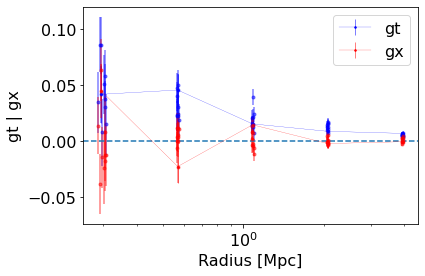

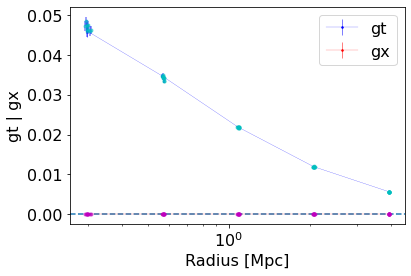

In [14]:
fig, ax = cls[0].plot_profiles() 

[ax.errorbar(cls[i].profile['radius'], cls[i].profile['gt'], yerr = cls[i].profile['gt_err'], alpha=0.5, ecolor='blue',fmt='b.') for i in range(N_stack)];
[ax.errorbar(cls[i].profile['radius'], cls[i].profile['gx'], yerr = cls[i].profile['gx_err'], alpha=0.5, ecolor='red',fmt='r.') for i in range(N_stack)];

ax.set_xscale('log')
ax.axhline(0,linestyle='dashed')
#ax.set_ylim(-0.1,0.25)

#__________________

fig, ax = cls_ideal[0].plot_profiles() 

[ax.errorbar(cls_ideal[i].profile['radius'], cls_ideal[i].profile['gt'], yerr = cls_ideal[i].profile['gt_err'], alpha=0.5, ecolor='blue',fmt='c.') for i in range(N_stack)];
[ax.errorbar(cls_ideal[i].profile['radius'], cls_ideal[i].profile['gx'], yerr = cls_ideal[i].profile['gx_err'], alpha=0.5, ecolor='red',fmt='m.') for i in range(N_stack)];

ax.set_xscale('log')
ax.axhline(0,linestyle='dashed')
#ax.set_ylim(-0.1,0.25)


## - Model construction

In [15]:
dict_profile = {'reduced shear': \
                {'model_func': clmm.theory.compute_reduced_tangential_shear, \
                'noise_func': lambda Ngal: noise_shear(Ngal , s_e),\
                'model_arg': 1., \
                'source_pdz': shear_pdz,\
                'source_density': n_e}}

In [16]:
lens_redshift = cluster_z
profile_type = "reduced shear"

In [17]:
bin_center, bin_edges, model, noise = profile_determination(rmin, rmax, radial_unit , lens_redshift, cluster_m , profile_type , dict_profile, cosmo, nbins, method=method, conc=concentration, delta_mdef=200, zinf=1e10)
bin_center, binedges, Ngal = compute_source_number_per_bin(rmin, rmax, radial_unit, lens_redshift, dict_profile[profile_type]['source_pdz'], dict_profile[profile_type]['source_density'], nbins, method, cosmo)

## - Profile noise and model construction

In [20]:
#impact of radial distribution

zinf = 1e10
Bs_mean = compute_Bs_mean(cluster_z, zinf, dict_profile[profile_type]['source_pdz'], cosmo.be_cosmo)

noise_radial = np.zeros((len(cls[0].profile['radius']), N_stack))
for i in range(N_stack ):
    for k in range(len(cls[i].profile['radius'])):
        if cls_ideal[i].profile['n_src'][k]>0:
            rgal_list  = cosmo.rad2mpc(cls_ideal[i].galcat["theta"][cls_ideal[i].profile['gal_id'][k]], cluster_z)
            noise_radial[k,i] = Bs_mean  * np.std(dict_profile[profile_type]['model_func'](rgal_list,cluster_m, concentration,cluster_z, zinf, cosmo,delta_mdef=200,halo_profile_model='nfw'))

In [21]:
#impact of redshift distribution
noise_zdistrib = np.zeros((len(cls[0].profile['radius']), N_stack))

for i in range(N_stack ):
    for k in range(len(cls[i].profile['radius'])):
        zgal_list  = cls_ideal[i].galcat["z"][cls_ideal[i].profile['gal_id'][k]]
        noise_zdistrib[k,i] = np.std(dict_profile[profile_type]['model_func'](cls_ideal[i].profile['radius'][k],
                                                  cluster_m, concentration,
                                                  cluster_z, zgal_list, cosmo,
                                                  delta_mdef=200,
                                                  halo_profile_model='nfw'))

In [22]:
gt_model3 = np.zeros((len(cls[0].profile['radius']), N_stack))
gt_noise_zdistrib_med = np.zeros((len(cls[0].profile['radius']), N_stack))
gt_noise_zdistrib_upp = np.zeros((len(cls[0].profile['radius']), N_stack))
gt_noise_zdistrib_low = np.zeros((len(cls[0].profile['radius']), N_stack))
gt_noise_zdistrib_std = np.zeros((len(cls[0].profile['radius']), N_stack))

for i in range(N_stack ):
    for k in range(len(cls[i].profile['radius'])):

        gt_model3[k,i] = np.mean( dict_profile[profile_type]['model_func'](cls[i].profile['radius'][k],
                                                  cluster_m, concentration,
                                                  cluster_z, mock_catalogs[i]['z'], cosmo,
                                                  delta_mdef=200,
                                                  halo_profile_model='nfw'))
 
        gt_noise_zdistrib_std[k,i] = np.std( dict_profile[profile_type]['model_func'](cls_ideal[i].profile['radius'][k],
                                                  cluster_m, concentration,
                                                  cluster_z, mock_catalogs_ideal[i]['z'], cosmo,
                                                  delta_mdef=200,
                                                  halo_profile_model='nfw'))
    
        gt_noise_zdistrib_med[k,i] = np.percentile( dict_profile[profile_type]['model_func'](cls_ideal[i].profile['radius'][k],
                                                  cluster_m, concentration,
                                                  cluster_z, mock_catalogs_ideal[i]['z'], cosmo,
                                                  delta_mdef=200,
                                                  halo_profile_model='nfw'), 50)        
               
        gt_noise_zdistrib_low[k,i] = np.percentile( dict_profile[profile_type]['model_func'](cls_ideal[i].profile['radius'][k],
                                                  cluster_m, concentration,
                                                  cluster_z, mock_catalogs_ideal[i]['z'], cosmo,
                                                  delta_mdef=200,
                                                  halo_profile_model='nfw'), 16)
        
        gt_noise_zdistrib_upp[k,i] = np.percentile( dict_profile[profile_type]['model_func'](cls_ideal[i].profile['radius'][k],
                                                  cluster_m, concentration,
                                                  cluster_z, mock_catalogs_ideal[i]['z'], cosmo,
                                                  delta_mdef=200,
                                                  halo_profile_model='nfw'), 84)

## - Noise contribution from the profile construction

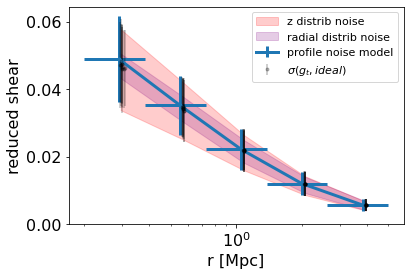

In [24]:

plt.errorbar(bin_center, model, xerr = [bin_center - bin_edges[0:-1], bin_edges[1:] - bin_center],fmt='.-', lw=3,\
             label='profile noise model', yerr = np.sqrt(noise_radial[:,i]**2 + noise_zdistrib[:,i]**2))


i = 0
plt.fill_between(cls[i].profile['radius'], gt_noise_zdistrib_low[:,i], gt_noise_zdistrib_upp[:,i], \
                 color='red', alpha=0.2, label='z distrib noise')
plt.fill_between(cls[i].profile['radius'], gt_model3[:,i] - noise_radial[:,i],gt_model3[:,i] + noise_radial[:,i],\
                 color='purple', alpha=0.2, label='radial distrib noise')


plt.errorbar(mock_profiles_ideal[N_stack-1]['radius'], mock_profiles_ideal[N_stack-1]['gt'],\
              yerr =mock_profiles_ideal[N_stack-1]['gt_err']*np.sqrt(mock_profiles_ideal[N_stack-1]['n_src']), \
              fmt='k.',alpha=0.25, label='$\sigma(g_t,ideal)$')

[plt.errorbar(mock_profiles_ideal[i]['radius'], mock_profiles_ideal[i]['gt'],\
              yerr =mock_profiles_ideal[i]['gt_err']*np.sqrt(mock_profiles_ideal[i]['n_src']), \
              fmt='k.',alpha=0.25) for i in range(N_stack-1)]


plt.ylim(0)
plt.xscale('log')

plt.legend(fontsize='x-small')

plt.ylabel(profile_type)
plt.xlabel('r [' + radial_unit + ']');

### =>The errors on the "ideal" mock data profiles are due to the redshift and radial distribution in each bin

## - Comparison of the measured and forecasted SNR

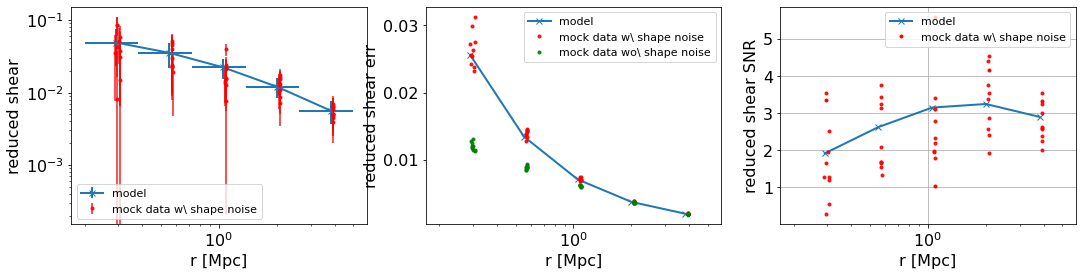

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,  figsize=(18,4), sharex=True, sharey=False)


#profile 
ax1.errorbar(bin_center, model, xerr = [bin_center - bin_edges[0:-1], bin_edges[1:] - bin_center],\
             yerr = noise ,fmt='-x', lw=2, label ='model')
ax1.errorbar(mock_profiles[N_stack-1]['radius'], mock_profiles[N_stack-1]['gt'], \
             yerr =mock_profiles[N_stack-1]['gt_err'], fmt='r.',alpha=0.9, \
             label='mock data w\ shape noise')
[ax1.errorbar(mock_profiles[i]['radius'], mock_profiles[i]['gt'], \
              yerr =mock_profiles[i]['gt_err'], fmt='r.',alpha=0.9) for i in range(N_stack-1)];


#errors
ax2.plot(bin_center, noise, 'x-',lw=2, label ='model')
ax2.plot(mock_profiles[N_stack-1]['radius'], mock_profiles[N_stack-1]['gt_err'], 'r.',\
         label='mock data w\ shape noise',alpha=0.9)
ax2.plot(mock_profiles[N_stack-1]['radius'], mock_profiles_ideal[N_stack-1]['gt_err']*np.sqrt(mock_profiles_ideal[N_stack-1]['n_src']), 'g.',\
         label='mock data wo\ shape noise',alpha=0.9)
[ax2.plot(mock_profiles[i]['radius'], mock_profiles[i]['gt_err'], 'r.',alpha=0.9)\
 for i in range(N_stack-1)];
[ax2.plot(mock_profiles_ideal[i]['radius'],mock_profiles_ideal[i]['gt_err']*np.sqrt(mock_profiles_ideal[i]['n_src']),\
          'g.',alpha=0.9) for i in range(N_stack-1)];


#SNR
ax3.plot(bin_center, model/noise,'x-',lw=2, label ='model')
ax3.plot(mock_profiles[N_stack-1]['radius'], mock_profiles[N_stack-1]['gt']/mock_profiles[N_stack-1]['gt_err'],\
         'r.',label='mock data w\ shape noise')
[ax3.plot(mock_profiles[i]['radius'], mock_profiles[i]['gt']/mock_profiles[i]['gt_err'],'r.',alpha=0.9)\
 for i in range(N_stack-1)];



ax1.legend(fontsize="x-small")
ax2.legend(fontsize="x-small")
ax3.legend(fontsize="x-small")

    
ax1.set_xscale('log')
ax1.set_yscale('log')

ax3.grid()

ax1.set_ylabel(profile_type)
ax1.set_xlabel('r [' + radial_unit + ']');

ax2.set_ylabel(profile_type + " err")
ax2.set_xlabel('r [' + radial_unit + ']');

ax3.set_ylabel(profile_type + " SNR")
ax3.set_xlabel('r [' + radial_unit + ']');


### => Good agreement between CLMM and my code when the signal is dominated by shape noise (and not errors due to the profile construction)